Here is the ultimate data cleaning cheatsheet for myself and you guys!<br>
Check [Ultimate Pandas Cheatsheet](https://www.kaggle.com/vivovinco/ultimate-cheatsheets-pandas) for more information.<br>
**If you're reading this, please upvote.**

First things first, load the libraries.

In [1]:
# libraries
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import fuzzywuzzy
from fuzzywuzzy import process

# for character encoding
import chardet

# for box-cox transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# set seed for reproducibility
np.random.seed(0) 

# 1. Fixing Missing Values

## 1.1. Load Data

In [2]:
# load data
sf_permits = pd.read_csv("../input/building-permit-applications-data/Building_Permits.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (22,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 1.2. Check Data

In [3]:
# check first 5 rows
sf_permits.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [4]:
# view column names
sf_permits.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units',
       'Plansets', 'TIDF Compliance', 'Existing Construction Type',
       'Existing Construction Type Description', 'Proposed Construction Type',
       'Proposed Construction Type Description', 'Site Permit',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location', 'Record ID'],
     

In [5]:
# quick summary
sf_permits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Permit Number                           198900 non-null  object 
 1   Permit Type                             198900 non-null  int64  
 2   Permit Type Definition                  198900 non-null  object 
 3   Permit Creation Date                    198900 non-null  object 
 4   Block                                   198900 non-null  object 
 5   Lot                                     198900 non-null  object 
 6   Street Number                           198900 non-null  int64  
 7   Street Number Suffix                    2216 non-null    object 
 8   Street Name                             198900 non-null  object 
 9   Street Suffix                           196132 non-null  object 
 10  Unit                                    2947

In [6]:
# detailed summary
sf_permits.describe().round(decimals=2)

,Permit Type,Street Number,Unit,Number of Existing Stories,Number of Proposed Stories,Estimated Cost,Revised Cost,Existing Units,Proposed Units,Plansets,Existing Construction Type,Proposed Construction Type,Supervisor District,Zipcode,Record ID
count,198900.00,198900.00,29479.00,156116.00,156032.00,1.608340e+05,1.928340e+05,147362.00,147989.00,161591.00,155534.00,155738.00,197183.00,197184.00,1.989000e+05
mean,7.52,1121.73,78.52,5.71,5.75,1.689554e+05,1.328562e+05,15.67,16.51,1.27,4.07,4.09,5.54,94115.50,1.162048e+12
std,1.46,1135.77,326.98,8.61,8.61,3.630386e+06,3.584903e+06,74.48,75.22,22.41,1.59,1.58,2.89,9.27,4.918215e+11
min,1.00,0.00,0.00,0.00,0.00,1.000000e+00,0.000000e+00,0.00,0.00,0.00,1.00,1.00,1.00,94102.00,1.293532e+10
25%,8.00,235.00,0.00,2.00,2.00,3.300000e+03,1.000000e+00,1.00,1.00,0.00,3.00,3.00,3.00,94109.00,1.308567e+12
50%,8.00,710.00,0.00,3.00,3.00,1.100000e+04,7.000000e+03,1.00,2.00,2.00,5.00,5.00,6.00,94114.00,1.371840e+12
75%,8.00,1700.00,1.00,4.00,4.00,3.500000e+04,2.870750e+04,4.00,4.00,2.00,5.00,5.00,8.00,94122.00,1.435000e+12
max,8.00,8400.00,6004.00,78.00,78.00,5.379586e+08,7.805000e+08,1907.00,1911.00,9000.00,5.00,5.00,11.00,94158.00,1.498342e+12


## 1.3. Check Missing Data

In [7]:
# get the number of missing data points per column
missing_values_count = sf_permits.isnull().sum()

# look at the number of missing points in the first 40 columns
missing_values_count[0:40]

Permit Number                                  0
Permit Type                                    0
Permit Type Definition                         0
Permit Creation Date                           0
Block                                          0
Lot                                            0
Street Number                                  0
Street Number Suffix                      196684
Street Name                                    0
Street Suffix                               2768
Unit                                      169421
Unit Suffix                               196939
Description                                  290
Current Status                                 0
Current Status Date                            0
Filed Date                                     0
Issued Date                                14940
Completed Date                            101709
First Construction Document Date           14946
Structural Notification                   191978
Number of Existing S

In [8]:
# how many total missing values do we have?
total_cells = np.product(sf_permits.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

26.26002315058403


## 1.4. Fix Missing Values
Be careful, you are about to remove some useful information and add some noise to your data.

### 1.4.1. Drop Missing Values: Rows

In [9]:
# remove all the rows that contain a missing value
sf_permits.dropna()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID


### 1.4.2. Drop Missing Values: Columns

In [10]:
# remove all columns with at least one missing value
sf_permits.dropna(axis=1)

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Name,Current Status,Current Status Date,Filed Date,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,Ellis,expired,12/21/2017,05/06/2015,1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,Geary,issued,08/03/2017,04/19/2016,1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,Pacific,withdrawn,09/26/2017,05/27/2016,1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,Pacific,complete,07/24/2017,11/07/2016,1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,Market,issued,12/01/2017,11/28/2016,144548169992
...,...,...,...,...,...,...,...,...,...,...,...,...
198895,M862628,8,otc alterations permit,12/05/2017,0113,017A,1228,Montgomery,issued,12/05/2017,12/05/2017,1489337276729
198896,201712055595,8,otc alterations permit,12/05/2017,0271,014,580,Bush,issued,12/06/2017,12/05/2017,1489462354993
198897,M863507,8,otc alterations permit,12/06/2017,4318,019,1568,Indiana,issued,12/06/2017,12/06/2017,1489539379952
198898,M863747,8,otc alterations permit,12/06/2017,0298,029,795,Sutter,issued,12/06/2017,12/06/2017,1489608233656


### 1.4.3. Replace Missing Values: with a Constant
Replace with mean or most frequent value per each column or a constant.

In [11]:
# check the most frequent element per each column
frequent = []

for col in sf_permits.columns:
    top_values = []
    top_values = sf_permits[col].mode()
    frequent.append(pd.DataFrame({col: top_values}).reset_index(drop=True))
pd.concat(frequent, axis=1).head(1)

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201602179765,8.0,otc alterations permit,09/15/2017,3708,001,1.0,A,Market,St,...,5.0,wood frame (5),5.0,wood frame (5),Y,3.0,Financial District/South Beach,94110.0,"(37.79226164705184, -122.4034859571375)",12935321500


In [12]:
# replace all NA's
sf_permits["Proposed Construction Type"].fillna(sf_permits["Proposed Construction Type"].mean(), inplace=True) # with mean
sf_permits["Proposed Construction Type Description"].fillna("wood frame (5)", inplace=True) # with frequent value
sf_permits["Site Permit"].fillna(1, inplace=True) # with a constant value
sf_permits.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,4.089529,wood frame (5),1,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,4.089529,wood frame (5),1,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.000000,constr type 1,1,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.000000,wood frame (5),1,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,4.089529,wood frame (5),1,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


### 1.4.4. Replace Missing Values: with Last/Next Value
"bfill" to use next valid observation to fill gap <br>
"ffill" to use last valid observation to fill gap <br>

Do not forget to handle all the remaining NA values.

In [13]:
# replace all NA's with the value that comes directly after it in the same column, 
# then replace all the remaining NA's with 0
sf_permits.fillna(method="bfill", axis=0).fillna(0).head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,A,Ellis,St,...,3.0,constr type 3,4.089529,wood frame (5),1,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,A,Geary,St,...,3.0,constr type 3,4.089529,wood frame (5),1,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,A,Pacific,Av,...,1.0,constr type 1,1.000000,constr type 1,1,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,A,Pacific,Av,...,5.0,wood frame (5),5.000000,wood frame (5),1,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,A,Market,St,...,3.0,constr type 3,4.089529,wood frame (5),1,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


# 2. Scaling and Normalization
Scaling: changing the range of your data <br>
Normalization: changing the shape of the distribution of your data

In [14]:
# load data
kickstarters_2017 = pd.read_csv("../input/kickstarter-projects/ks-projects-201801.csv")

## 2.1. Scaling
This means that you're transforming your data so that it fits within a specific scale, like 0-100 or 0-1.<br>
You want to scale data when you're using methods based on measures of how far apart data points are, 
like support vector machines (SVM) or k-nearest neighbors (KNN). <br>
With these algorithms, a change of "1" in any numeric feature is given the same importance.

For example, you might be looking at the prices of some products in both Yen and US Dollars. <br>
One US Dollar is worth about 100 Yen, but if you don't scale your prices, <br>
methods like SVM or KNN will consider a difference in price of 1 Yen as important as a difference of 1 US Dollar!

In [15]:
# select the usd_goal_real column
original_data = pd.DataFrame(kickstarters_2017.usd_goal_real)

# scale the goals from 0 to 1
scaled_data = minmax_scaling(original_data, columns=["usd_goal_real"])

print("Original data\nPreview:\n", original_data.head())
print("Minimum value:", float(original_data.min()),
      "\nMaximum value:", float(original_data.max()))
print("_"*30)

print("\nScaled data\nPreview:\n", scaled_data.head())
print("Minimum value:", float(scaled_data.min()),
      "\nMaximum value:", float(scaled_data.max()))

Original data
Preview:
    usd_goal_real
0        1533.95
1       30000.00
2       45000.00
3        5000.00
4       19500.00
Minimum value: 0.01 
Maximum value: 166361390.71
______________________________

Scaled data
Preview:
    usd_goal_real
0       0.000009
1       0.000180
2       0.000270
3       0.000030
4       0.000117
Minimum value: 0.0 
Maximum value: 1.0


## 2.2. Normalization
Scaling just changes the range of your data. Normalization is a more radical transformation. <br>
The point of normalization is to change your observations so that they can be described as a normal distribution.

In general, you'll normalize your data if you're going to be using a machine learning or statistics technique that assumes your data is normally distributed. <br>
Some examples of these include linear discriminant analysis (LDA) and Gaussian naive Bayes. <br>
(Pro tip: any method with "Gaussian" in the name probably assumes normality.)

In [16]:
# get the index of all positive pledges (Box-Cox only takes positive values)
index_of_positive_pledges = kickstarters_2017.usd_pledged_real > 0

# get only positive pledges (using their indexes)
positive_pledges = kickstarters_2017.usd_pledged_real.loc[index_of_positive_pledges]

# normalize the pledges (w/ Box-Cox)
normalized_pledges = pd.Series(stats.boxcox(positive_pledges)[0], 
                               name="usd_pledged_real", index=positive_pledges.index)

print("Original data\nPreview:\n", positive_pledges.head())
print("Minimum value:", float(positive_pledges.min()),
      "\nMaximum value:", float(positive_pledges.max()))
print("_"*30)

print("\nNormalized data\nPreview:\n", normalized_pledges.head())
print("Minimum value:", float(normalized_pledges.min()),
      "\nMaximum value:", float(normalized_pledges.max()))

Original data
Preview:
 1     2421.0
2      220.0
3        1.0
4     1283.0
5    52375.0
Name: usd_pledged_real, dtype: float64
Minimum value: 0.45 
Maximum value: 20338986.27
______________________________

Normalized data
Preview:
 1    10.165142
2     6.468598
3     0.000000
4     9.129277
5    15.836853
Name: usd_pledged_real, dtype: float64
Minimum value: -0.7779954122762203 
Maximum value: 30.69054020451361


# 3. Recognizing Date and Time

## 3.1. Load Data

In [17]:
# load data
earthquakes = pd.read_csv("../input/earthquake-database/database.csv")

## 3.2. Check Data

In [18]:
earthquakes.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [19]:
# check for any misfit date format
date_lengths = earthquakes.Date.str.len()
date_lengths.value_counts()

10    23409
24        3
Name: Date, dtype: int64

In [20]:
# find the misfits
indices = np.where([date_lengths == 24])[1]
print('Indices with corrupted data:', indices)
earthquakes.loc[indices]

Indices with corrupted data: [ 3378  7512 20650]


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A09,US,US,US,Reviewed
7512,1985-04-28T02:53:41.530Z,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,NaN,NaN,5.6,MW,...,NaN,NaN,NaN,NaN,1.30,USP0002E81,US,US,HRV,Reviewed
20650,2011-03-13T02:23:34.520Z,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,13.9,289.0,5.8,MWC,...,NaN,32.3,NaN,NaN,1.06,USP000HWQP,US,US,GCMT,Reviewed


## 3.3. Convert Date to Datetime
Some format examples: <br>
* 1/17/07 has the format "%m/%d/%y"
* 17-1-2007 has the format "%d-%m-%Y"

In [21]:
# fix the misfits and convert to datetime
earthquakes.loc[3378, "Date"] = "02/23/1975"
earthquakes.loc[7512, "Date"] = "04/28/1985"
earthquakes.loc[20650, "Date"] = "03/13/2011"
earthquakes['date_parsed'] = pd.to_datetime(earthquakes['Date'], format="%m/%d/%Y")

In [22]:
# check again for any misfit date format
date_lengths = earthquakes.Date.str.len()
date_lengths.value_counts()

10    23412
Name: Date, dtype: int64

## 3.4. Select and Plot the Date

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='date_parsed'>

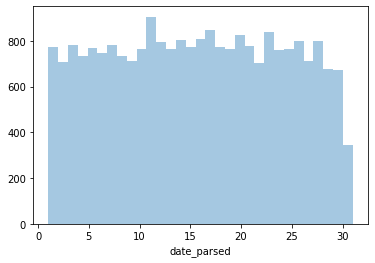

In [23]:
# select the day of the month
day_of_month_earthquakes = earthquakes['date_parsed'].dt.day

# remove na's
day_of_month_earthquakes = day_of_month_earthquakes.dropna()

# plot the day of the month
sns.distplot(day_of_month_earthquakes, kde=False, bins=31)

# 4. Avoiding Character Errors
Avoiding unknown characters such as:
* æ–‡å—åŒ–ã??
* ����������

## 4.1. Character Encodings
There are two main data types: string (text) or bytes (integers).

In [24]:
# check to see what datatype it is
sample_entry = b'\xa7A\xa6n'
print(sample_entry)
print('data type:', type(sample_entry))

b'\xa7A\xa6n'
data type: <class 'bytes'>


In [25]:
# convert it back to utf-8
new_entry1 = sample_entry.decode("big5-tw")
new_entry2 = sample_entry.decode("big5-tw").encode("utf-8", errors="replace")

print(new_entry1)
print(new_entry2)

你好
b'\xe4\xbd\xa0\xe5\xa5\xbd'


## 4.2. Loading Files with Encoding Problems
Error message: "UnicodeDecodeError"

In [26]:
# look at the first ten thousand bytes to guess the character encoding
with open("../input/kickstarter-projects/ks-projects-201801.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [27]:
# read in the file with the encoding detected by chardet
kickstarter_2016 = pd.read_csv("../input/kickstarter-projects/ks-projects-201612.csv", encoding='Windows-1252')

kickstarter_2016.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


In [28]:
# save the file (will be saved as UTF-8 by default!)
kickstarter_2016.to_csv("ks-projects-201801-utf8.csv")

# 5. Fixing Typos

In [29]:
# load data
professors = pd.read_csv("../input/pakistan-intellectual-capital/pakistan_intellectual_capital.csv")

In [30]:
professors.head()

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,Software Engineering & DBMS,NaN
1,4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,DBMS,NaN
2,5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"Information processing, Multimedia mining",NaN
3,6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
4,24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,Pakistan,2005.0,VLSI Electronics DLD Database,NaN


## 5.1. "Country" Column

In [31]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array([' Germany', ' New Zealand', ' Sweden', ' USA', 'Australia',
       'Austria', 'Canada', 'China', 'Finland', 'France', 'Greece',
       'HongKong', 'Ireland', 'Italy', 'Japan', 'Macau', 'Malaysia',
       'Mauritius', 'Netherland', 'New Zealand', 'Norway', 'Pakistan',
       'Portugal', 'Russian Federation', 'Saudi Arabia', 'Scotland',
       'Singapore', 'South Korea', 'SouthKorea', 'Spain', 'Sweden',
       'Thailand', 'Turkey', 'UK', 'USA', 'USofA', 'Urbana', 'germany'],
      dtype=object)

In [32]:
# convert to lower case
professors['Country'] = professors['Country'].str.lower()

# remove trailing white spaces
professors['Country'] = professors['Country'].str.strip()

In [33]:
# get all the unique values in the 'Country' column to check again
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea',
       'southkorea', 'spain', 'sweden', 'thailand', 'turkey', 'uk',
       'urbana', 'usa', 'usofa'], dtype=object)

In [34]:
# get the top 10 closest matches to "south korea"
matches = fuzzywuzzy.process.extract("south korea", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# take a look at them
matches

[('south korea', 100),
 ('southkorea', 48),
 ('saudi arabia', 43),
 ('norway', 35),
 ('austria', 33),
 ('ireland', 33),
 ('pakistan', 32),
 ('portugal', 32),
 ('scotland', 32),
 ('australia', 30)]

In [35]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("Done!")

In [36]:
replace_matches_in_column(df=professors, column='Country', string_to_match="south korea")

Done!


In [37]:
# get all the unique values in the 'Country' column to check again!
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea', 'spain',
       'sweden', 'thailand', 'turkey', 'uk', 'urbana', 'usa', 'usofa'],
      dtype=object)

## 5.2. "Graduated from" Column

In [38]:
# get all the unique values in the 'Graduated from' column to check again!
unis = professors['Graduated from'].unique()

# sort them alphabetically and then take a closer look
unis.sort()
unis

array([' Columbia University', ' Delft University of Technology',
       ' Iowa State University', ' University of Central Florida',
       ' University of Innsbruck',
       ' University of Texas at Arlington (UTA)', ' University of Turin',
       'Abasyn University', 'Abdul Wali Khan University, Mardan',
       'Abdus Salam School of Mathematical Sciences,GC University',
       'Agricultural University Peshawar', 'Allama Iqbal Open University',
       'Asian Institute of Technology', 'Aston University, Birmingham',
       'Australian National University, Caneberra', 'BUKC',
       'Bahauddin Zakariya University', 'Bahria University',
       'Bahria University,Islamabad',
       'Balochistan University of Information Technology, Engineering and Management Sciences',
       'Barani Institute of Information Technology',
       'Beaconhouse National University', 'Beihang University',
       'Beijing Institute of Technology',
       'Beijing Institute of Technology Beijing',
       'Beiji

In [39]:
# remove white strips at the beginning and end of cells
professors['Graduated from'] = professors['Graduated from'].str.strip()

## 5.3. Change Column Name

In [40]:
professors.rename(columns={"Province University Located" : "Location of Province University"}, inplace=True)
professors

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Location of Province University,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,thailand,NaN,Software Engineering & DBMS,NaN
1,4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,thailand,NaN,DBMS,NaN
2,5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,thailand,NaN,"Information processing, Multimedia mining",NaN
3,6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
4,24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,pakistan,2005.0,VLSI Electronics DLD Database,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,1974,1975,Dr. Ahmar Rashid,Ghulam Ishaq Khan Institute,Computer Science and Engineering,KPK,Associate Professor,PhD,JNU,south korea,NaN,"Electrical Impedance Tomography, Inverse algor...",NaN
1138,1975,1976,Dr. Fawad Hussain,Ghulam Ishaq Khan Institute,Computer Science and Engineering,KPK,Associate Professor,PhD,Grenoble,france,NaN,"Machine Learning, Big Data Anaysis, Data Minin...",NaN
1139,1977,1978,Dr. Rashad M Jillani,Ghulam Ishaq Khan Institute,Computer Science and Engineering,KPK,Assistant Professor,PhD,Florida Atlantic University,usa,2012.0,"Digital Multimedia Systems, Video Compression ...",NaN
1140,1979,1980,Dr. Shahabuddin Ansari,Ghulam Ishaq Khan Institute,Computer Science and Engineering,KPK,Assistant Professor,PhD,Ghulam Ishaq Khan Institute of Science and Tec...,pakistan,NaN,"Medical Image Processing and Analysis, Digital...",NaN


**To be continued...**